# PREDIKSI SAHAM NETFLIX MENGGUNAKAN XGBOOST

**Import Library**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

**Membaca Dataset**

In [ ]:
file_path = 'Netflix 2014 - 2023.csv'
df = pd.read_csv(file_path)
print(df.head())


         date       open       high        low      close    volume  \
0  2014-01-02  52.401428  52.511429  51.542858  51.831429  12325600   
1  2014-01-03  52.000000  52.495712  51.842857  51.871429  10817100   
2  2014-01-06  51.889999  52.044285  50.475716  51.367142  15501500   
3  2014-01-07  49.684284  49.698570  48.152859  48.500000  36167600   
4  2014-01-08  48.104286  49.425713  48.074287  48.712856  20001100   

       rsi_7     rsi_14       cci_7      cci_14     sma_50     ema_50  \
0  34.729664  49.183584  -89.573201 -131.288579  50.112828  50.235157   
1  35.587886  49.457208  -65.820581 -103.026189  50.228771  50.299327   
2  29.820674  46.087900 -121.472559 -139.640566  50.312571  50.341203   
3  14.371863  32.522091 -206.762171 -238.029120  50.336228  50.268997   
4  18.049045  34.073549 -117.836707 -180.766801  50.373257  50.207969   

     sma_100    ema_100      macd  bollinger  TrueRange     atr_7    atr_14  \
0  46.385428  46.650698  0.751929  52.607357   1.052857

 **Preprocessing**                                                           

*   Type kolom tanggal diubah menjadi datetime
*   Menghapus kolom yang tidak diperlukan : 'next day close'
*   Menghapus data yang mengandung NaN

In [2]:
 df['date'] = pd.to_datetime(df['date'])

In [3]:
jumlah_kolom_sebelum = df.shape[1]

if 'next_day_close' in df.columns:
    df.drop(columns=['next_day_close'], inplace=True)

jumlah_kolom_setelah = df.shape[1]
jumlah_kolom_dihapus = jumlah_kolom_sebelum - jumlah_kolom_setelah

print(f'Jumlah kolom sebelum penghapusan: {jumlah_kolom_sebelum}')
print(f'Jumlah kolom setelah penghapusan: {jumlah_kolom_setelah}')
print(f'Jumlah kolom yang dihapus: {jumlah_kolom_dihapus}')


Jumlah kolom sebelum penghapusan: 20
Jumlah kolom setelah penghapusan: 19
Jumlah kolom yang dihapus: 1


In [4]:
df.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'rsi_7', 'rsi_14',
       'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'macd',
       'bollinger', 'TrueRange', 'atr_7', 'atr_14'],
      dtype='object')

In [5]:
jumlah_sebelum = df.shape[0]
df.dropna(inplace=True)
jumlah_setelah = df.shape[0]
jumlah_dihapus = jumlah_sebelum - jumlah_setelah

print(f'Jumlah baris sebelum penghapusan: {jumlah_sebelum}')
print(f'Jumlah baris setelah penghapusan: {jumlah_setelah}')
print(f'Jumlah baris yang dihapus: {jumlah_dihapus}')

Jumlah baris sebelum penghapusan: 2516
Jumlah baris setelah penghapusan: 2516
Jumlah baris yang dihapus: 0


**Feature Engineering** (Menambahkan 5 fitur tambahan = 9 kolom)


*   Fitur Weighted Moving Average (WMA_10, WMA_20)
*   Fitur Stochastic Oscillator (%K, %D)
*   Fitur Volume Weighted Average Price (VWAP)
*   Fitur Rate Of Change (ROC)
*   Fitur Moving Average Oscillator (EMA_FAST, EMA_SLOW, MAO)




In [6]:
# WMA 10 dan WMA 20
def wma(data, window):
    weights = np.arange(1, window+1)
    return data.rolling(window=window).apply(lambda prices: np.dot(prices, weights) / weights.sum(), raw=True)

df['wma_10'] = wma(df['close'], 10)
df['wma_20'] = wma(df['close'], 20)


In [7]:
# Stochastic Oscillator
low_min = df['low'].rolling(window=14).min()
high_max = df['high'].rolling(window=14).max()
df['%K'] = 100 * ((df['close'] - low_min) / (high_max - low_min))
df['%D'] = df['%K'].rolling(window=3).mean()


In [8]:
#VWAP
df['VWAP'] = (df['close'] * df['volume']).cumsum() / df['volume'].cumsum()


In [9]:
# ROC 12
df['ROC'] = df['close'].pct_change(periods=12) * 100


In [10]:
# MAO (Fast MA - Slow MA)
fast_period = 12
slow_period = 26

df['EMA_fast'] = df['close'].ewm(span=fast_period, adjust=False).mean()
df['EMA_slow'] = df['close'].ewm(span=slow_period, adjust=False).mean()
df['MAO'] = df['EMA_fast'] - df['EMA_slow']


In [11]:
df.head(20)

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,...,atr_14,wma_10,wma_20,%K,%D,VWAP,ROC,EMA_fast,EMA_slow,MAO
0,2014-01-02,52.401428,52.511429,51.542858,51.831429,12325600,34.729664,49.183584,-89.573201,-131.288579,...,1.247748,NaN,NaN,NaN,NaN,51.831429,NaN,51.831429,51.831429,0.000000
1,2014-01-03,52.000000,52.495712,51.842857,51.871429,10817100,35.587886,49.457208,-65.820581,-103.026189,...,1.206072,NaN,NaN,NaN,NaN,51.850125,NaN,51.837583,51.834392,0.003191
2,2014-01-06,51.889999,52.044285,50.475716,51.367142,15501500,29.820674,46.087900,-121.472559,-139.640566,...,1.231965,NaN,NaN,NaN,NaN,51.656384,NaN,51.765207,51.799781,-0.034574
3,2014-01-07,49.684284,49.698570,48.152859,48.500000,36167600,14.371863,32.522091,-206.762171,-238.029120,...,1.373559,NaN,NaN,NaN,NaN,50.130437,NaN,51.262868,51.555353,-0.292485
4,2014-01-08,48.104286,49.425713,48.074287,48.712856,20001100,18.049045,34.073549,-117.836707,-180.766801,...,1.371978,NaN,NaN,NaN,NaN,49.831394,NaN,50.870558,51.344797,-0.474239
5,2014-01-09,48.824287,49.139999,47.857143,48.150002,17007200,15.937607,31.979692,-88.168749,-153.839927,...,1.365612,NaN,NaN,NaN,NaN,49.575664,NaN,50.452011,51.108146,-0.656135
6,2014-01-10,48.295715,48.377144,47.218571,47.448570,16237900,13.620921,29.543217,-87.125001,-138.847973,...,1.350824,NaN,NaN,NaN,NaN,49.305946,NaN,49.989943,50.837066,-0.847123
7,2014-01-13,47.304287,49.810001,47.304287,48.115715,27237000,25.618425,34.643516,-46.121866,-92.974324,...,1.433316,NaN,NaN,NaN,NaN,49.097193,NaN,49.701600,50.635485,-0.933884
8,2014-01-14,48.777142,48.799999,47.509998,48.279999,19740000,28.472575,35.874531,-54.555994,-83.144577,...,1.423079,NaN,NaN,NaN,NaN,49.005032,NaN,49.482893,50.461004,-0.978112
9,2014-01-15,47.857143,48.367142,45.581429,47.197144,40432000,21.985262,31.643736,-162.118705,-102.226930,...,1.520410,48.358130,NaN,NaN,NaN,48.665785,NaN,49.131239,50.219237,-1.087998


**Melihat Outlier pada setiap Kolom**

        date       open       high        low      close    volume      rsi_7  \
0 2014-01-02  52.401428  52.511429  51.542858  51.831429  12325600  34.729664   
1 2014-01-03  52.000000  52.495712  51.842857  51.871429  10817100  35.587886   
2 2014-01-06  51.889999  52.044285  50.475716  51.367142  15501500  29.820674   
3 2014-01-07  49.684284  49.698570  48.152859  48.500000  36167600  14.371863   
4 2014-01-08  48.104286  49.425713  48.074287  48.712856  20001100  18.049045   

      rsi_14       cci_7      cci_14  ...    atr_14  wma_10  wma_20  %K  %D  \
0  49.183584  -89.573201 -131.288579  ...  1.247748     NaN     NaN NaN NaN   
1  49.457208  -65.820581 -103.026189  ...  1.206072     NaN     NaN NaN NaN   
2  46.087900 -121.472559 -139.640566  ...  1.231965     NaN     NaN NaN NaN   
3  32.522091 -206.762171 -238.029120  ...  1.373559     NaN     NaN NaN NaN   
4  34.073549 -117.836707 -180.766801  ...  1.371978     NaN     NaN NaN NaN   

        VWAP  ROC   EMA_fast   EMA_slo

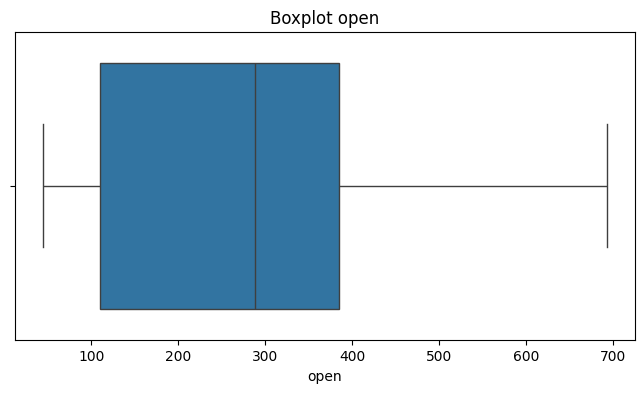

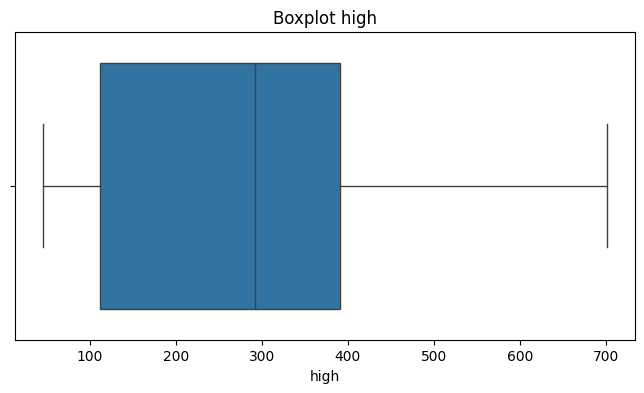

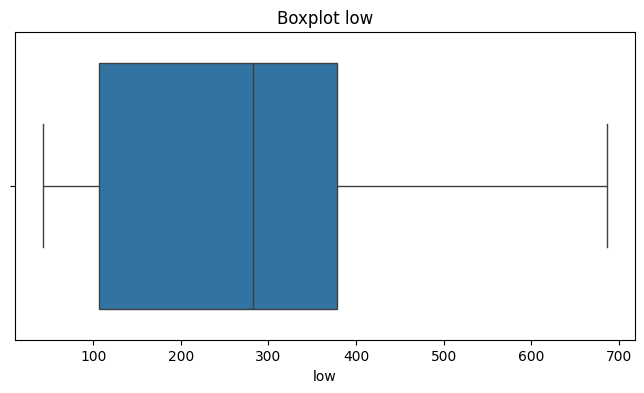

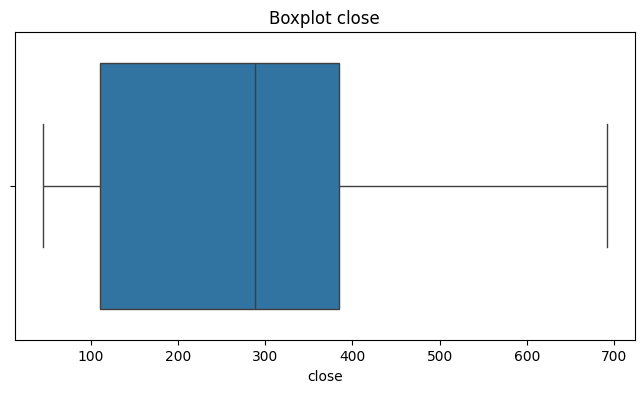

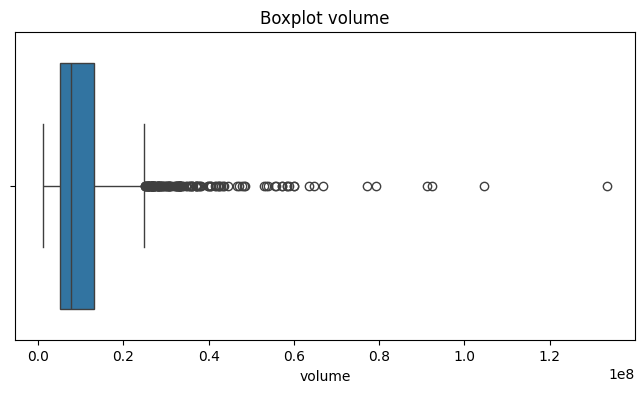

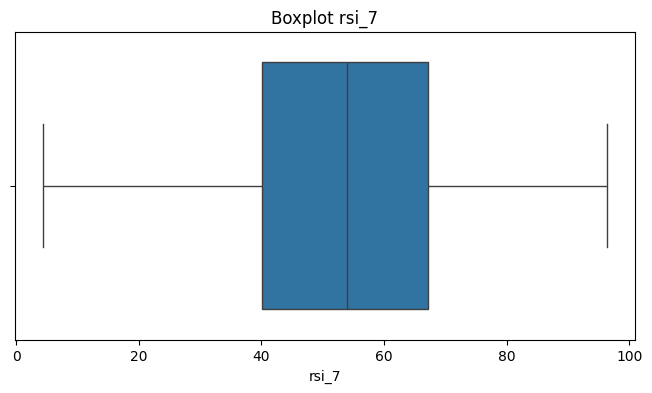

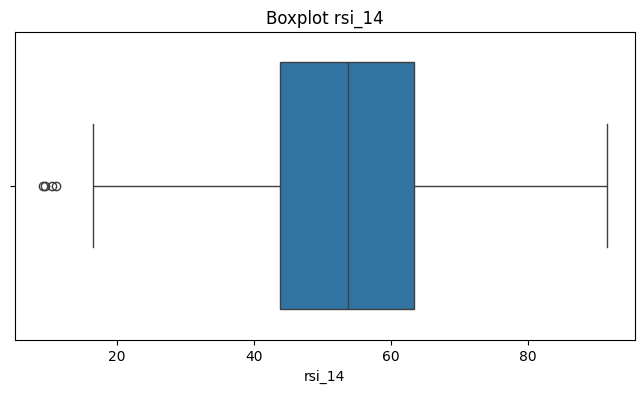

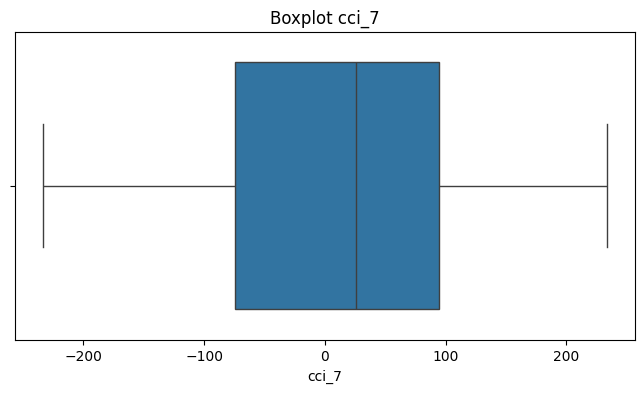

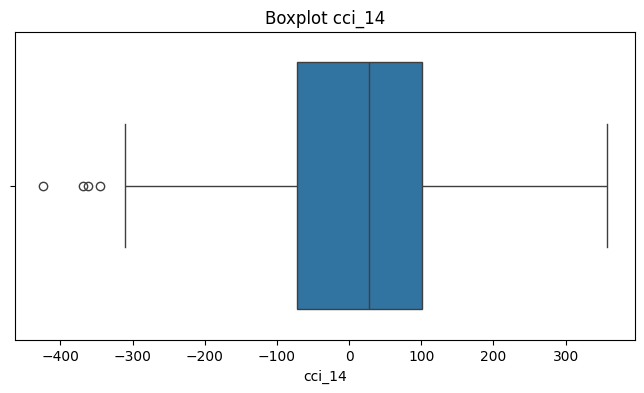

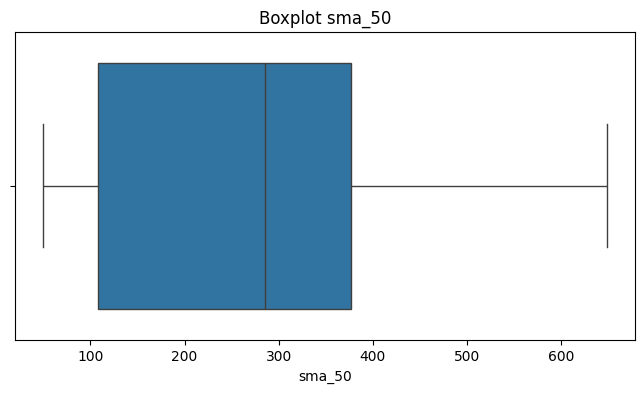

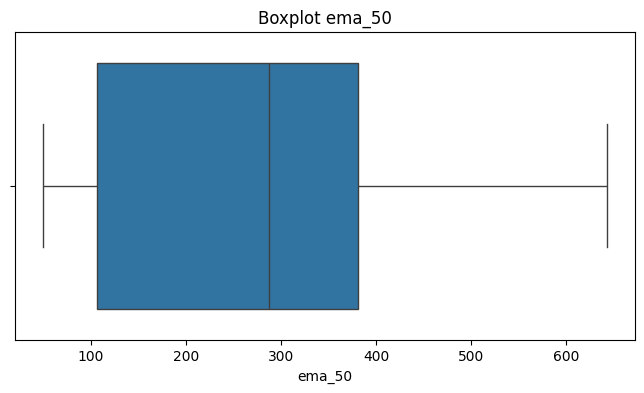

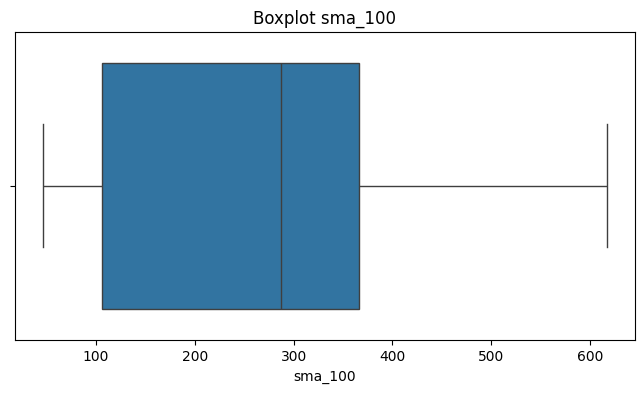

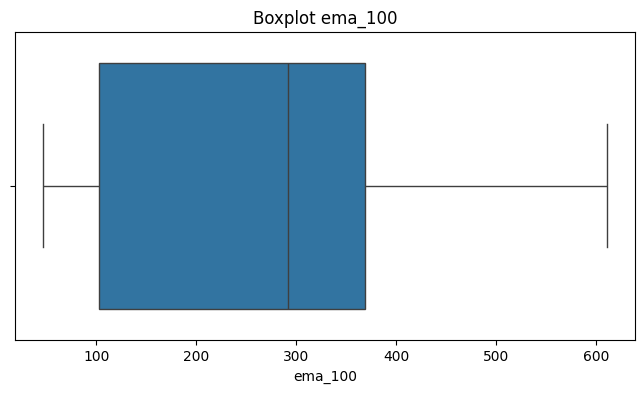

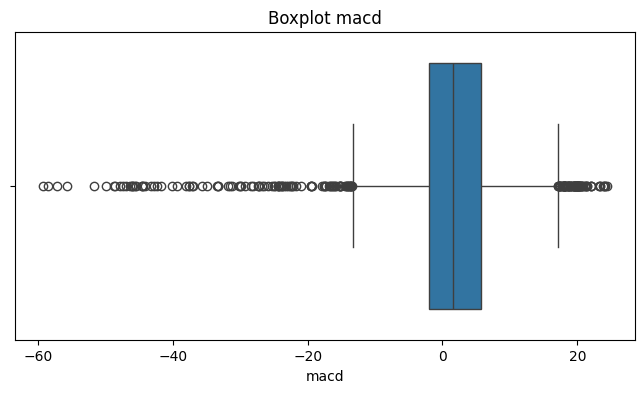

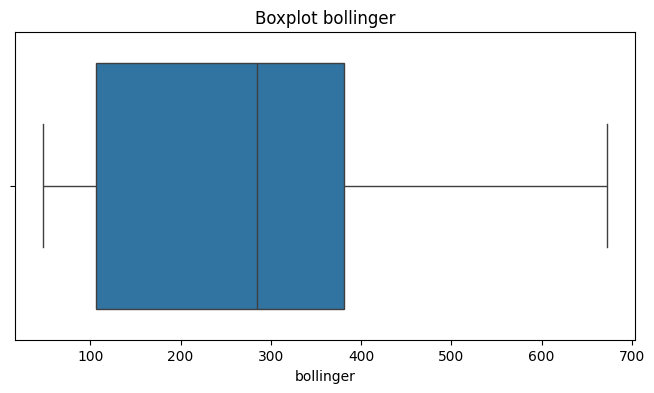

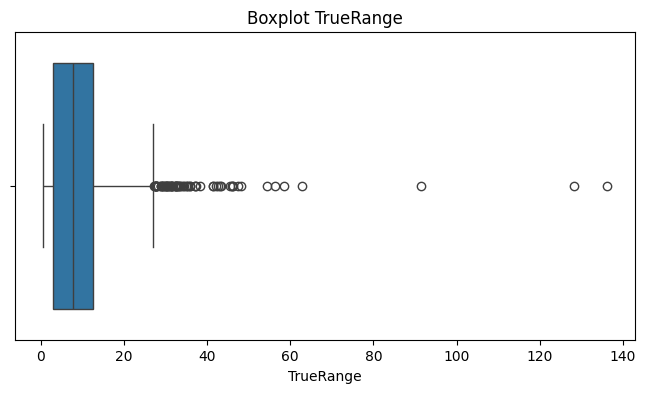

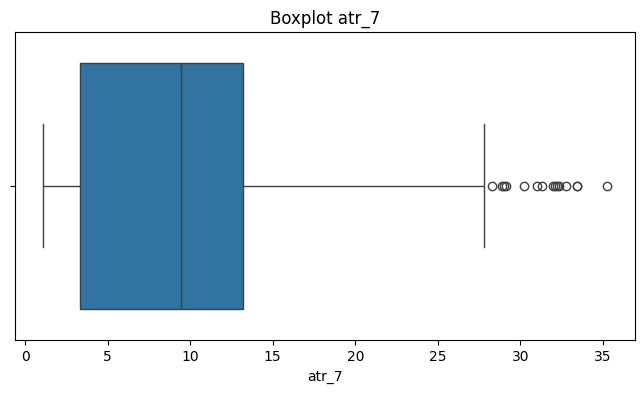

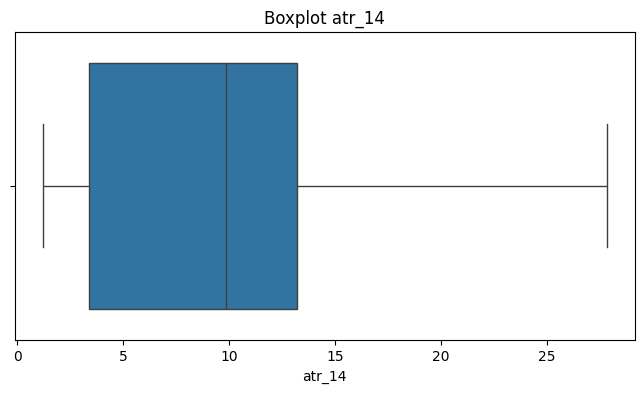

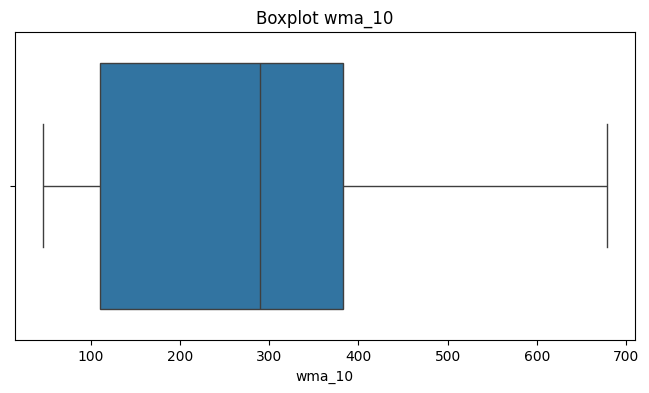

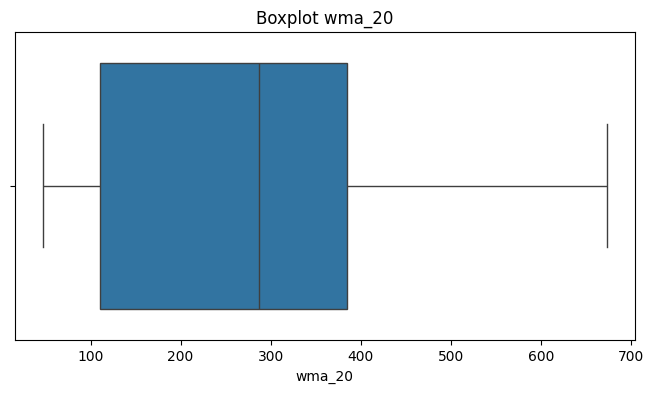

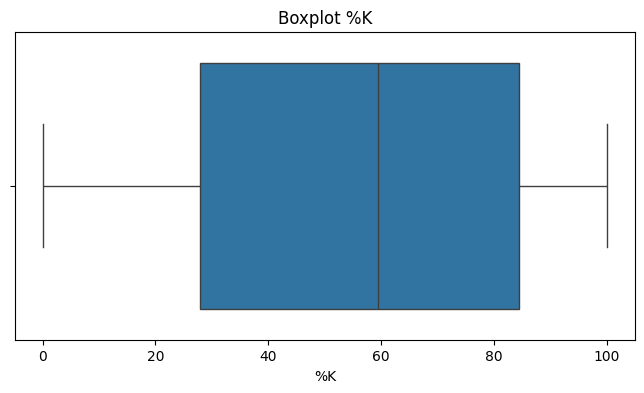

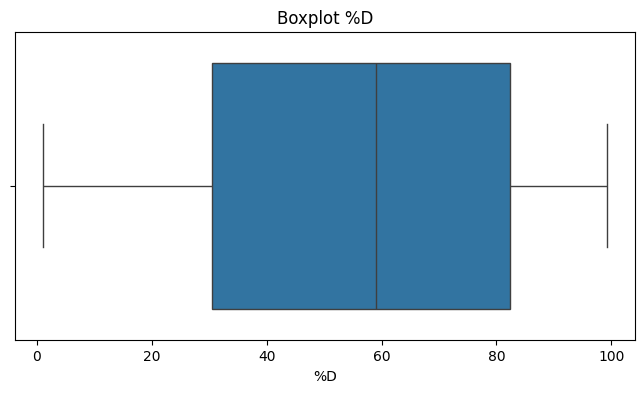

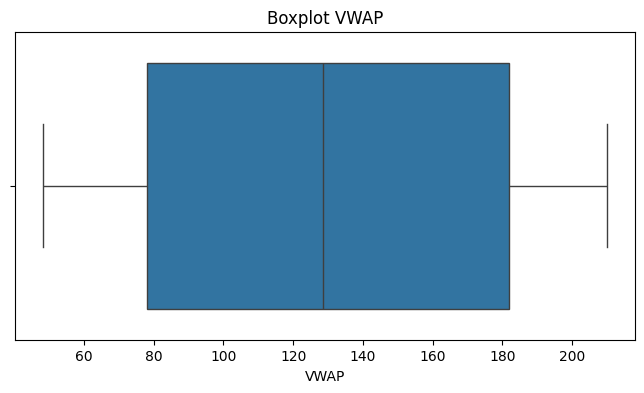

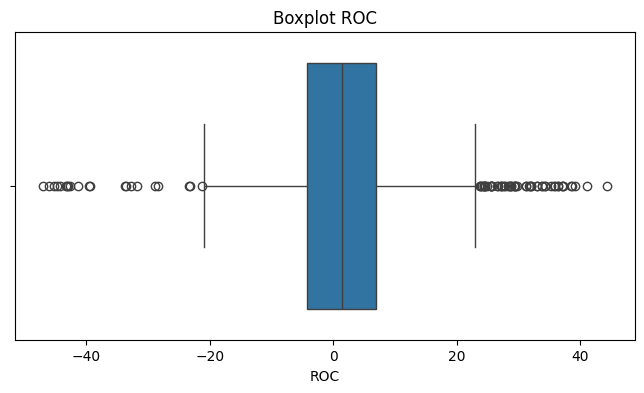

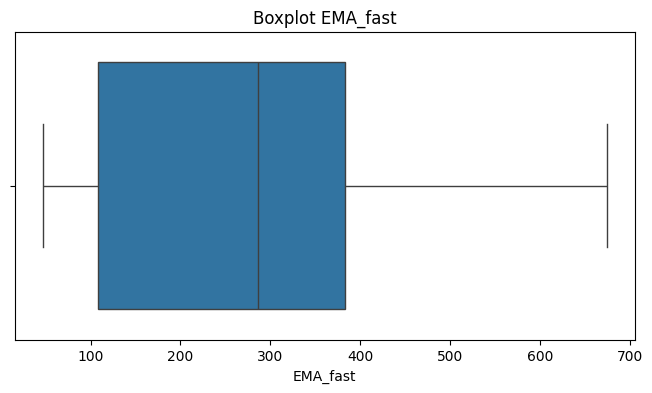

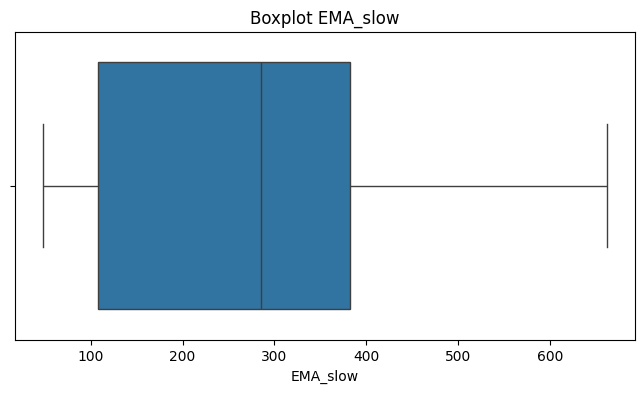

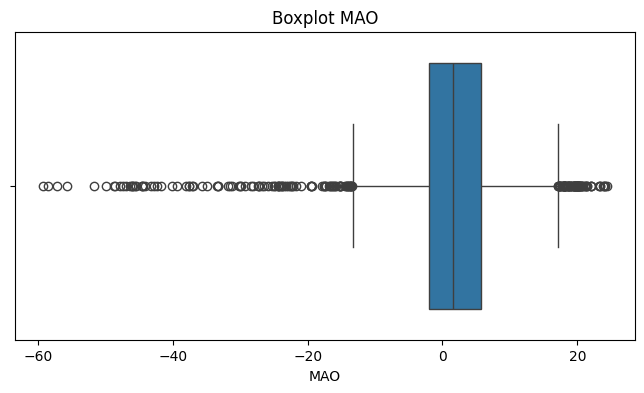


Kolom dengan Outlier Terbanyak:
macd: 185 outliers
MAO: 185 outliers
volume: 135 outliers
ROC: 78 outliers
TrueRange: 70 outliers
atr_7: 15 outliers
rsi_14: 4 outliers
cci_14: 4 outliers
open: 0 outliers
high: 0 outliers
low: 0 outliers
close: 0 outliers
rsi_7: 0 outliers
cci_7: 0 outliers
sma_50: 0 outliers
ema_50: 0 outliers
sma_100: 0 outliers
ema_100: 0 outliers
bollinger: 0 outliers
atr_14: 0 outliers
wma_10: 0 outliers
wma_20: 0 outliers
%K: 0 outliers
%D: 0 outliers
VWAP: 0 outliers
EMA_fast: 0 outliers
EMA_slow: 0 outliers


In [ ]:
print(df.head())

if 'close' not in df.columns:
    raise ValueError("Kolom 'close' tidak ditemukan dalam dataset!")

# List kolom numerik (selain kolom tanggal atau kategorikal)
numerical_columns = df.select_dtypes(include=[np.number]).columns

print("Descriptive Statistics:")
print(df[numerical_columns].describe())

def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound) | (column > upper_bound)

outlier_summary = {}
for col in numerical_columns:
    outliers = detect_outliers_iqr(df[col])
    outlier_summary[col] = outliers.sum()

for col in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot {col}")
    plt.xlabel(col)
    plt.show()

sorted_outliers = sorted(outlier_summary.items(), key=lambda x: x[1], reverse=True)
print("\nKolom dengan Outlier Terbanyak:")
for col, count in sorted_outliers:
    print(f"{col}: {count} outliers")

**Menghilangkan Outlier**

In [ ]:
# Fungsi untuk menghapus outlier berdasarkan IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # Kuartil pertama
    Q3 = df[column].quantile(0.75)  # Kuartil ketiga
    IQR = Q3 - Q1  # Rentang antar kuartil

    lower_bound = Q1 - 1.5 * IQR  # Batas bawah
    upper_bound = Q3 + 1.5 * IQR  # Batas atas

    # Filter df yang berada dalam batas
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Kolom yang mengandung outlier
columns_with_outliers = ['rsi_14', 'cci_14', 'macd', 'TrueRange', 'atr_7', 'ROC', 'MAO']

# Hapus outlier untuk setiap kolom hingga tidak ada outlier
for column in columns_with_outliers:
    if column in df.columns:
        while True:
            before_removal = len(df)
            df = remove_outliers_iqr(df, column)
            after_removal = len(df)
            outliers_removed = before_removal - after_removal
            if outliers_removed == 0:
                break
        print(f"Kolom '{column}': outliers berhasil dihapus sepenuhnya")
    else:
        print(f"Kolom '{column}' tidak ditemukan dalam dataset.")

# Cek jumlah baris setelah penghapusan
print(f"Jumlah baris setelah penghapusan outlier: {len(df)}")

# Fungsi untuk mendeteksi outlier berdasarkan IQR
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound) | (column > upper_bound)

# Periksa apakah masih ada outlier
outlier_summary = {}
for col in columns_with_outliers:
    if col in df.columns:
        outliers = detect_outliers_iqr(df[col])
        outlier_summary[col] = outliers.sum()

print("\nStatus Outlier Setelah Pembersihan:")
for col, count in outlier_summary.items():
    print(f"{col}: {count} outliers")

# Simpan dataset yang sudah dibersihkan ke file baru
df.to_csv('Netflix_Cleaned.csv', index=False)
print("Dataset cleaned disimpan ke 'Netflix_Cleaned.csv'")

Kolom 'rsi_14': outliers berhasil dihapus sepenuhnya
Kolom 'cci_14': outliers berhasil dihapus sepenuhnya
Kolom 'macd': outliers berhasil dihapus sepenuhnya
Kolom 'TrueRange': outliers berhasil dihapus sepenuhnya
Kolom 'atr_7': outliers berhasil dihapus sepenuhnya
Kolom 'ROC': outliers berhasil dihapus sepenuhnya
Kolom 'MAO': outliers berhasil dihapus sepenuhnya
Jumlah baris setelah penghapusan outlier: 1821

Status Outlier Setelah Pembersihan:
rsi_14: 3 outliers
cci_14: 2 outliers
macd: 0 outliers
TrueRange: 13 outliers
atr_7: 1 outliers
ROC: 1 outliers
MAO: 0 outliers
Dataset cleaned disimpan ke 'Netflix_Cleaned.csv'


In [ ]:
# Fungsi untuk menghapus outlier berdasarkan IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # Kuartil pertama
    Q3 = df[column].quantile(0.75)  # Kuartil ketiga
    IQR = Q3 - Q1  # Rentang antar kuartil

    lower_bound = Q1 - 1.5 * IQR  # Batas bawah
    upper_bound = Q3 + 1.5 * IQR  # Batas atas

    # Filter df yang berada dalam batas
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Kolom yang mengandung outlier
columns_with_outliers = ['rsi_14', 'cci_14', 'TrueRange', 'atr_7', 'ROC']

# Hapus outlier untuk setiap kolom hingga tidak ada outlier
for column in columns_with_outliers:
    if column in df.columns:
        while True:
            before_removal = len(df)
            df = remove_outliers_iqr(df, column)
            after_removal = len(df)
            outliers_removed = before_removal - after_removal
            if outliers_removed == 0:
                break
        print(f"Kolom '{column}': outliers berhasil dihapus sepenuhnya")
    else:
        print(f"Kolom '{column}' tidak ditemukan dalam dataset.")

# Cek jumlah baris setelah penghapusan
print(f"Jumlah baris setelah penghapusan outlier: {len(df)}")

# Fungsi untuk mendeteksi outlier berdasarkan IQR
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound) | (column > upper_bound)

# Periksa apakah masih ada outlier
outlier_summary = {}
for col in columns_with_outliers:
    if col in df.columns:
        outliers = detect_outliers_iqr(df[col])
        outlier_summary[col] = outliers.sum()

print("\nStatus Outlier Setelah Pembersihan:")
for col, count in outlier_summary.items():
    print(f"{col}: {count} outliers")

# Simpan dataset yang sudah dibersihkan ke file baru
df.to_csv('Netflix_Cleaned.csv', index=False)
print("Dataset cleaned disimpan ke 'Netflix_Cleaned.csv'")

Kolom 'rsi_14': outliers berhasil dihapus sepenuhnya
Kolom 'cci_14': outliers berhasil dihapus sepenuhnya
Kolom 'TrueRange': outliers berhasil dihapus sepenuhnya
Kolom 'atr_7': outliers berhasil dihapus sepenuhnya
Kolom 'ROC': outliers berhasil dihapus sepenuhnya
Jumlah baris setelah penghapusan outlier: 1799

Status Outlier Setelah Pembersihan:
rsi_14: 0 outliers
cci_14: 0 outliers
TrueRange: 2 outliers
atr_7: 0 outliers
ROC: 0 outliers
Dataset cleaned disimpan ke 'Netflix_Cleaned.csv'


In [ ]:
# Fungsi untuk menghapus outlier berdasarkan IQR
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # Kuartil pertama
    Q3 = df[column].quantile(0.75)  # Kuartil ketiga
    IQR = Q3 - Q1  # Rentang antar kuartil

    lower_bound = Q1 - 1.5 * IQR  # Batas bawah
    upper_bound = Q3 + 1.5 * IQR  # Batas atas

    # Filter df yang berada dalam batas
    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered

# Kolom yang mengandung outlier
columns_with_outliers = ['TrueRange']

# Hapus outlier untuk kolom TrueRange hingga tidak ada outlier
for column in columns_with_outliers:
    if column in df.columns:
        while True:
            before_removal = len(df)
            df = remove_outliers_iqr(df, column)
            after_removal = len(df)
            outliers_removed = before_removal - after_removal
            if outliers_removed == 0:
                break
        print(f"Kolom '{column}': outliers berhasil dihapus sepenuhnya")
    else:
        print(f"Kolom '{column}' tidak ditemukan dalam dataset.")

# Cek jumlah baris setelah penghapusan
print(f"Jumlah baris setelah penghapusan outlier: {len(df)}")

# Fungsi untuk mendeteksi outlier berdasarkan IQR
def detect_outliers_iqr(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column < lower_bound) | (column > upper_bound)

# Periksa apakah masih ada outlier
outlier_summary = {}
for col in columns_with_outliers:
    if col in df.columns:
        outliers = detect_outliers_iqr(df[col])
        outlier_summary[col] = outliers.sum()

print("\nStatus Outlier Setelah Pembersihan:")
for col, count in outlier_summary.items():
    print(f"{col}: {count} outliers")

# Simpan dataset yang sudah dibersihkan ke file baru
df.to_csv('Netflix_Cleaned.csv', index=False)
print("Dataset cleaned disimpan ke 'Netflix_Cleaned.csv'")

Kolom 'TrueRange': outliers berhasil dihapus sepenuhnya
Jumlah baris setelah penghapusan outlier: 1797

Status Outlier Setelah Pembersihan:
TrueRange: 0 outliers
Dataset cleaned disimpan ke 'Netflix_Cleaned.csv'


**Mengganti Nilai NaN menjadi 0**

In [17]:
# Isi nilai NaN dengan 0
df = df.fillna(0)
df.head(20)

,date,open,high,low,close,volume,rsi_7,rsi_14,cci_7,cci_14,...,atr_14,wma_10,wma_20,%K,%D,VWAP,ROC,EMA_fast,EMA_slow,MAO
12,2014-01-21,47.461430,47.495712,45.750000,46.958572,25220300,22.568292,31.397439,-95.256526,-90.172398,...,1.508627,47.523533,0.000000,0.000000,0.000000,48.324064,-9.401356,48.346299,49.586969,-1.240670
13,2014-01-22,47.071430,47.777142,46.764286,47.675713,48342000,37.437932,37.493251,-5.306036,-60.070865,...,1.473215,47.502857,0.000000,30.220548,0.000000,48.228093,-8.088684,48.243132,49.445395,-1.202263
14,2014-01-23,55.342857,56.518570,53.927143,55.531429,91280000,81.888106,69.482575,233.333333,249.714166,...,1.999618,48.925481,0.000000,90.974415,0.000000,49.823472,8.106908,49.364409,49.896212,-0.531804
15,2014-01-24,54.811428,55.814285,54.768570,55.154285,35466900,78.754073,67.691481,115.868391,196.982406,...,1.931482,50.155558,0.000000,87.526128,69.573697,50.240536,13.720175,50.255159,50.285699,-0.030540
16,2014-01-27,55.341431,55.928570,52.937141,54.461430,32526900,72.783733,64.406795,68.078928,140.125646,...,2.007193,51.132312,0.000000,81.191246,86.563929,50.523115,11.800938,50.902277,50.595012,0.307265
17,2014-01-28,54.474285,58.201427,54.394287,58.110001,43590400,81.431855,72.087814,81.569867,146.512057,...,2.135760,52.644935,0.000000,99.275547,89.330973,51.147759,20.685355,52.011158,51.151678,0.859480
18,2014-01-29,57.588570,58.191429,56.864285,57.202858,28968100,74.559639,68.150000,75.492024,120.516377,...,2.078002,53.810910,0.000000,92.087408,90.851400,51.461871,20.557602,52.809881,51.599914,1.209967
19,2014-01-30,58.157143,58.455715,57.358570,57.810001,18379200,76.132436,69.356511,85.001005,103.871339,...,2.019063,54.925040,52.166340,94.984467,95.449141,51.664150,20.147858,53.579130,52.059920,1.519210
26,2014-02-10,61.347141,61.767143,60.611427,61.491428,13812400,82.804963,74.794154,137.592798,137.551420,...,1.904399,59.181143,56.811551,98.162250,97.606029,53.122360,10.732659,57.629570,55.041499,2.588071
27,2014-02-11,61.422855,62.251431,60.787144,61.998569,13667500,84.091544,75.726958,98.790585,168.480404,...,1.872962,59.793272,57.553204,97.285225,98.325271,53.288855,12.409342,58.301724,55.556838,2.744887


In [18]:
# Simpan dataset yang sudah dibersihkan ke file baru
df.to_csv('Netflix_Cleaned.csv', index=False)
print("Dataset cleaned disimpan ke 'Netflix_Cleaned.csv'")

Dataset cleaned disimpan ke 'Netflix_Cleaned.csv'


**Data Splitting**

In [ ]:
target = 'close'
predictors = [
    'open', 'high', 'low', 'volume', 'rsi_7', 'rsi_14',
    'cci_7', 'cci_14', 'sma_50', 'ema_50', 'sma_100', 'ema_100',
    'macd', 'bollinger', 'TrueRange', 'atr_7', 'atr_14',
    '%K', '%D', 'VWAP', 'ROC', 'EMA_fast', 'EMA_slow', 'MAO', 'wma_10', 'wma_20'
]

X = df[predictors]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [20]:
X_train.head()

,open,high,low,volume,rsi_7,rsi_14,cci_7,cci_14,sma_50,ema_50,...,atr_14,%K,%D,VWAP,ROC,EMA_fast,EMA_slow,MAO,wma_10,wma_20
2406,424.200012,425.260010,415.589996,6009200,34.781757,45.258446,-75.035136,-127.020551,414.709000,414.935329,...,14.284686,10.200283,12.360234,205.533636,-4.310516,437.819031,432.993897,4.825134,438.026912,441.496381
930,182.550003,185.330002,180.639999,6689600,78.780572,68.431639,149.487233,144.730107,172.094200,171.201602,...,4.355268,99.126175,90.148124,86.783506,10.123112,176.913984,174.392485,2.521499,178.925455,174.986381
2247,316.459991,322.769989,310.920013,8423000,64.716686,62.035064,77.980383,110.576326,268.939401,274.294213,...,13.088056,78.261807,89.640957,198.145155,2.146921,299.526602,288.626550,10.900052,302.738184,296.985859
207,54.250000,55.267143,54.049999,11736900,42.031644,37.882841,67.625396,-27.436116,63.816486,61.337693,...,2.283811,40.309520,38.358040,56.998723,-14.568215,56.202511,59.241974,-3.039463,54.016182,56.969755
1000,187.940002,189.110001,185.259995,6545400,50.912959,47.910473,-33.226518,25.078029,193.373000,189.719482,...,4.433934,73.211826,64.035324,90.244518,2.597269,188.555597,189.779573,-1.223976,188.474546,188.037476


In [21]:
y_train.head()

2406    422.670013
930     185.149994
2247    312.589996
207      55.174286
1000    188.820007
Name: close, dtype: float64

**MODEL XGBOOST & MENGECEK PREDIKSI MENGGUNAKAN MSE, RMSE, DAN R2**

In [ ]:
# Tentukan parameter yang ingin dicari
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 6, 8, 10]
}

# Tentukan estimator
estimator = XGBRegressor(random_state=42)

# Grid Search untuk pencarian hyperparameter
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  # Gunakan MSE untuk skor
    cv=5,  # Cross-validation dengan 5 fold
    n_jobs=-1
)

# Melatih model dengan GridSearchCV
grid_search.fit(X_train, y_train)

# Fungsi untuk mencetak hasil evaluasi
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f'MSE: {mse:.2f}')
    print(f'RMSE: {rmse:.2f}')
    print(f'R²: {r2:.2f}')

# Menampilkan setiap hasil dari setiap kombinasi parameter
for params in grid_search.cv_results_['params']:
    # Buat model baru dengan kombinasi parameter yang ada
    model = XGBRegressor(random_state=42, **params)
    model.fit(X_train, y_train)  # Latih model dengan parameter tersebut

    print(f"\nKetika estimators {params['n_estimators']}, lr {params['learning_rate']}, md {params['max_depth']}")

    # Evaluasi model
    evaluate_model(model, X_test, y_test)


Ketika estimators 50, lr 0.01, md 3
MSE: 9551.02
RMSE: 97.73
R²: 0.63

Ketika estimators 100, lr 0.01, md 3
MSE: 3579.25
RMSE: 59.83
R²: 0.86

Ketika estimators 200, lr 0.01, md 3
MSE: 517.91
RMSE: 22.76
R²: 0.98

Ketika estimators 300, lr 0.01, md 3
MSE: 87.01
RMSE: 9.33
R²: 1.00

Ketika estimators 50, lr 0.01, md 6
MSE: 9540.00
RMSE: 97.67
R²: 0.63

Ketika estimators 100, lr 0.01, md 6
MSE: 3551.66
RMSE: 59.60
R²: 0.86

Ketika estimators 200, lr 0.01, md 6
MSE: 504.29
RMSE: 22.46
R²: 0.98

Ketika estimators 300, lr 0.01, md 6
MSE: 79.88
RMSE: 8.94
R²: 1.00

Ketika estimators 50, lr 0.01, md 8
MSE: 9539.90
RMSE: 97.67
R²: 0.63

Ketika estimators 100, lr 0.01, md 8
MSE: 3551.42
RMSE: 59.59
R²: 0.86

Ketika estimators 200, lr 0.01, md 8
MSE: 504.37
RMSE: 22.46
R²: 0.98

Ketika estimators 300, lr 0.01, md 8
MSE: 80.30
RMSE: 8.96
R²: 1.00

Ketika estimators 50, lr 0.01, md 10
MSE: 9539.91
RMSE: 97.67
R²: 0.63

Ketika estimators 100, lr 0.01, md 10
MSE: 3551.46
RMSE: 59.59
R²: 0.86

Ketik

In [ ]:
# Load data
file_path = 'Netflix_Cleaned.csv'  # Ganti dengan lokasi file Anda
data = pd.read_csv(file_path)

# Bersihkan nama kolom
data.columns = data.columns.str.strip()

# Konversi kolom tanggal
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

# Pilih fitur yang relevan
features = ['open', 'high', 'low', 'close', 'volume', 'wma_10', 'wma_20', '%K', '%D',
            'VWAP', 'ROC', 'EMA_fast', 'EMA_slow', 'MAO']

# Latih model menggunakan data sebelum Desember 2023
train_data = data[data['date'] < datetime(2023, 12, 1)]
X_train = train_data[features]
y_train = train_data['close']

# Split data untuk cross-validation dan training
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Inisialisasi model
model = XGBRegressor(random_state=42, n_estimators=1000, learning_rate=0.05, max_depth=6)

# Hyperparameter tuning menggunakan GridSearchCV
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 1000, 1500],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Tampilkan parameter terbaik
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Gunakan model terbaik dari grid search
best_model = grid_search.best_estimator_

# Evaluasi menggunakan cross-validation untuk menghindari overfitting
cv_results = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_results)  # Menghitung RMSE dari hasil MSE yang negatif

# Prediksi pada data validasi
y_pred = best_model.predict(X_valid)
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, y_pred)

# Tampilkan hasil evaluasi
print(f'Cross-Validation MSE: {cv_results.mean()}')
print(f'Cross-Validation RMSE: {cv_rmse.mean()}')
print(f'Mean Absolute Error (MAE) pada data validasi: {mean_absolute_error(y_valid, y_pred)}')
print(f'Mean Squared Error (MSE) pada data validasi: {mse}')
print(f'Root Mean Squared Error (RMSE) pada data validasi: {rmse}')
print(f'R² pada data validasi: {r2}')

# Buat data untuk Januari 2024
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 1, 31)
future_dates = pd.date_range(start=start_date, end=end_date, freq='B')  # Hari kerja saja

# Gunakan data terakhir sebagai dasar
latest_data = data.iloc[-1].copy()

# Generate data untuk prediksi masa depan
future_data = []
predicted_close_values = []

for date in future_dates:
    # Gunakan data terakhir untuk prediksi pertama
    open_price = latest_data['close']

    # Perhitungan fitur berdasarkan pola historis
    high_price = open_price * (1 + np.random.uniform(0.005, 0.015))  # High naik 0.5%-1.5%
    low_price = open_price * (1 - np.random.uniform(0.005, 0.015))  # Low turun 0.5%-1.5%
    volume = latest_data['volume'] * (1 + np.random.uniform(-0.1, 0.1))  # Volume ±10%

    # Gunakan fitur teknikal dari data terakhir (sekarang sudah menggunakan data asli, bukan dummy)
    row = {
        'date': date,
        'open': open_price,
        'high': high_price,
        'low': low_price,
        'close': open_price,  # Dummy close
        'volume': volume,
        'wma_10': latest_data['wma_10'],  # Asli dari data
        'wma_20': latest_data['wma_20'],  # Asli dari data
        '%K': latest_data['%K'],  # Asli dari data
        '%D': latest_data['%D'],  # Asli dari data
        'VWAP': latest_data['VWAP'],  # Asli dari data
        'ROC': latest_data['ROC'],  # Asli dari data
        'EMA_fast': latest_data['EMA_fast'],  # Asli dari data
        'EMA_slow': latest_data['EMA_slow'],  # Asli dari data
        'MAO': latest_data['MAO'],  # Asli dari data
    }
    future_data.append(row)

    # Pisahkan fitur dan prediksi harga close
    future_row = pd.DataFrame([row])
    X_future = future_row[features]
    predicted_close = best_model.predict(X_future)[0]
    predicted_close_values.append(predicted_close)

# Tambahkan hasil prediksi ke data
future_data = pd.DataFrame(future_data)
future_data['predicted_close'] = predicted_close_values

# Tampilkan hasil prediksi
print("Prediksi Harga 'Close' untuk Januari 2024:")
print(future_data[['date', 'predicted_close']])

# Simpan hasil prediksi ke file CSV
future_data[['date', 'predicted_close']].to_csv('prediksi_januari_2024_akurat.csv', index=False)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
Best Hyperparameters: {'colsample_bytree': 0.9, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1500, 'subsample': 0.9}
Cross-Validation MSE: -4.83654928623759
Cross-Validation RMSE: 2.134861845741044
Mean Absolute Error (MAE) pada data validasi: 0.9685312855604158
Mean Squared Error (MSE) pada data validasi: 9.413513489969958
Root Mean Squared Error (RMSE) pada data validasi: 3.068144959086835
R² pada data validasi: 0.9996365987802815
Prediksi Harga 'Close' untuk Januari 2024:
         date  predicted_close
0  2024-01-01       486.153473
1  2024-01-02       486.168518
2  2024-01-03       486.168518
3  2024-01-04       486.153473
4  2024-01-05       486.153473
5  2024-01-08       486.153473
6  2024-01-09       486.132996
7  2024-01-10       486.172241
8  2024-01-11       486.168518
9  2024-01-12       486.172241
10 2024-01-15       486.153473
11 2024-01-16       486.172241
12 2024-01-17       486.168518
13 2024-01-18